In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Load necessary libraries
library(tidyverse)
library(rsample)
library(lubridate)


players <- read_csv("https://raw.githubusercontent.com/amy897324/dsci-100-group-34/refs/heads/main/players.csv")
sessions <- read_delim("https://raw.githubusercontent.com/amy897324/dsci-100-group-34/refs/heads/main/sessions.csv", delim = ",")


merge_data <- merge(players, sessions, by = "hashedEmail")


day_and_hour <- merge_data |> 
    mutate(
        date_start_time = dmy_hm(start_time),
        day_of_week = wday(date_start_time, label = TRUE),
        hour_of_day = hour(date_start_time),
        date_end_time = dmy_hm(end_time),
        day_of_week = as.factor(day_of_week),
        hour_of_day = as.factor(hour_of_day)
    ) |> 
    select(experience, day_of_week, hour_of_day, name)


using <- day_and_hour |>  #you can change the variable name
    group_by(day_of_week, hour_of_day, experience) |> 
    summarize(avg_players = n(), .groups = "drop")


set.seed(123) #you can change
data_split <- initial_split(using, prop = 0.75)
data_training <- training(data_split)
data_testing <- testing(data_split)

data_training


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


day_of_week,hour_of_day,experience,avg_players
<ord>,<fct>,<chr>,<int>
Wed,15,Beginner,2
Sun,4,Amateur,12
Wed,21,Beginner,1
⋮,⋮,⋮,⋮
Sun,16,Regular,2
Mon,5,Regular,3
Thu,3,Amateur,7


In [21]:
data_training <- data_training |>
  mutate(
    day_of_week = as.integer(day_of_week, levels = levels(data_training$day_of_week),  ordered = FALSE),
    experience = as.integer(experience, levels = levels(data_training$experience)),
      hour_of_day = as.integer(hour_of_day, levels = levels(data_training$experience)),
      
  )

data_testing <- data_testing |>
  mutate(
    day_of_week = as.integer(day_of_week, levels = levels(data_testing$day_of_week),  ordered = FALSE),
    experience = as.integer(experience, levels = levels(data_testing$experience))
  )


session_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")


recipe <- recipe(hour_of_day ~ day_of_week + experience, data = data_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


cv_splits <- vfold_cv(data_training, v = 5)

workflow <- workflow() |>
  add_recipe(recipe) |>
  add_model(session_spec)

tune_results <- tune_grid(
  workflow,
  resamples = cv_splits,
  grid = 10 
)

tune_metrics <- tune_results |>
collect_metrics()

tune_metrics

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,9.4366263,5,0.285861970,Preprocessor1_Model01
2,rsq,standard,0.0049074,5,0.002590185,Preprocessor1_Model01
3,rmse,standard,9.1025690,5,0.311094879,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,rsq,standard,0.01817393,5,0.003998023,Preprocessor1_Model09
14,rmse,standard,8.04390689,5,0.179418240,Preprocessor1_Model10
14,rsq,standard,0.02229248,5,0.007618379,Preprocessor1_Model10


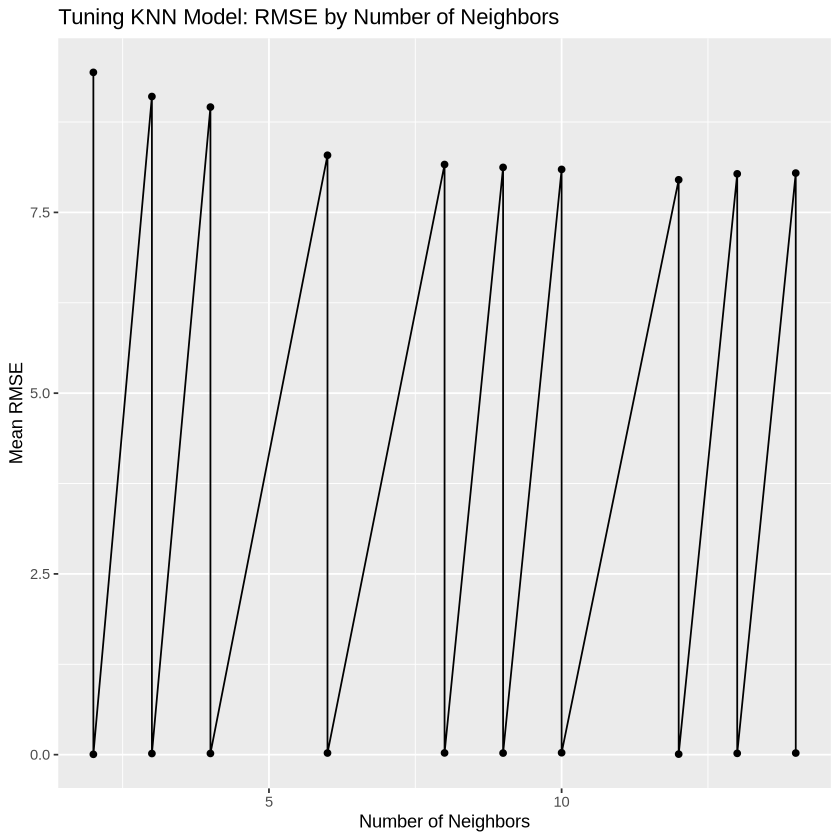

In [22]:
ggplot(tune_metrics, aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "Tuning KNN Model: RMSE by Number of Neighbors",
       x = "Number of Neighbors",
       y = "Mean RMSE") 

In [23]:
best_neighbors <- tune_metrics |>
  filter(.metric == "rmse") |>
  arrange(mean) |>
  slice(1) |>
  pull(neighbors)

best_neighbors

final_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbors) |>
  set_engine("kknn") |>
  set_mode("regression")

final_fit <- fit(final_model, avg_players ~ day_of_week + hour_of_day + experience, data = data_training)
predictions <- predict(final_fit, new_data = data_testing)


predictions 


# results <- predictions |>
#   bind_cols(data_testing)
# rmse_value <- rmse(results, truth = avg_players, estimate = .pred)
# rmse_value



[1] 12

.pred
<dbl>
7.916667
8.416667
8.083333
⋮
7.666667
5.916667
7.666667


In [24]:
results <- bind_cols(data_testing, predictions)
results 

day_of_week,hour_of_day,experience,avg_players,.pred
<int>,<fct>,<int>,<int>,<dbl>
1,0,5,1,7.916667
1,2,1,6,8.416667
1,2,4,4,8.083333
⋮,⋮,⋮,⋮,⋮
7,22,2,1,7.666667
7,23,1,10,5.916667
7,23,5,1,7.666667


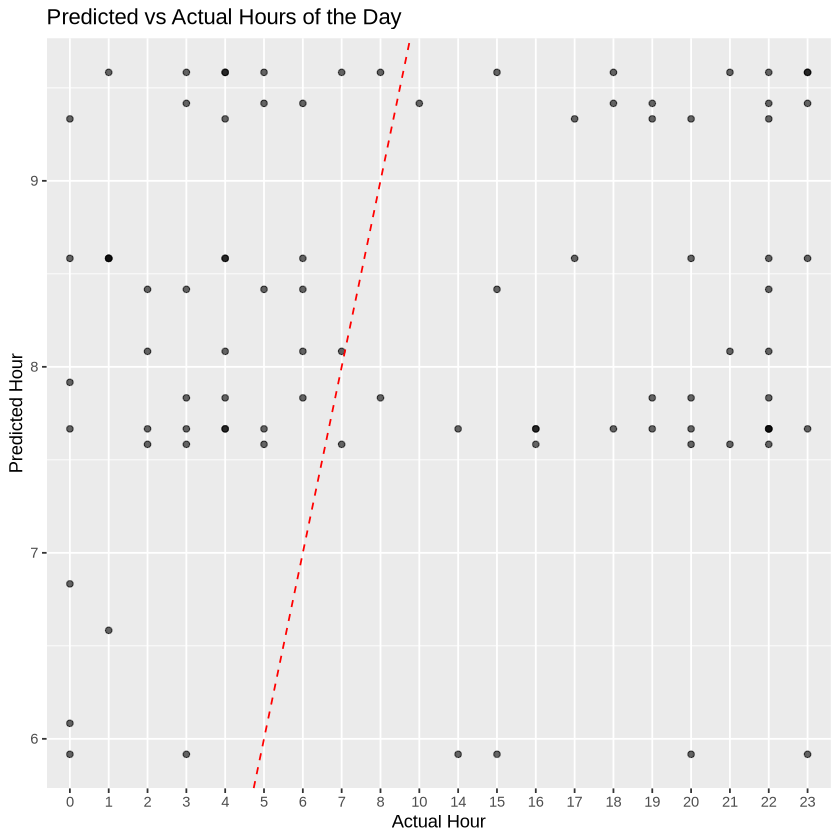

In [25]:
ggplot(results, aes(x = hour_of_day, y = .pred)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +  # Line of perfect prediction
  labs(title = "Predicted vs Actual Hours of the Day", x = "Actual Hour", y = "Predicted Hour")

In [26]:
hourly_predictions <- results |>
  group_by(.pred) |>
  summarize(total_players = n())


busiest_hour <- hourly_predictions %>%
  filter(total_players == max(total_players))

busiest_hour

.pred,total_players
<dbl>,<int>
7.666667,16
